In [1]:
%load_ext autoreload
%autoreload 2

In [142]:
import sys
sys.path.append('..')
from quotaclimat.data_processing.sitemap_processing import load_all

import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud


stopwords = stopwords.words('french')
pd.options.display.max_colwidth = 200



In [61]:
df = load_all("../data_public/sitemap_dumps/")


In [4]:
df.columns

Index(['url', 'news', 'news_publication', 'publication_name',
       'publication_language', 'news_publication_date', 'news_title', 'image',
       'image_loc', 'image_caption', 'news_keywords', 'sitemap', 'etag',
       'sitemap_last_modified', 'sitemap_size_mb', 'download_date', 'media',
       'section', 'lastmod', 'news_genres', 'changefreq', 'priority',
       'news_access'],
      dtype='object')

# Feature engineering

In [7]:
print(df.news_publication_date.min())
print(df.news_publication_date.max())

1995-02-17 00:03:19
2022-12-02 00:20:07


In [62]:
# format date
df['news_publication_date'] = df.news_publication_date.dt.strftime("%Y-%m-%d")
df['download_date'] = df.download_date.dt.strftime("%Y-%m-%d")
# filtering
df = df[df.news_publication_date > '2022-11-24']  # some article are very old

# extract section 
mlb = MultiLabelBinarizer()
df_sparse = pd.DataFrame(mlb.fit_transform(df.section),columns=mlb.classes_, index=df.index)
df[df_sparse.columns] = df_sparse

# news title processing
df.news_title = df.news_title.str.lower()


/var/folders/v6/vd9wd_yd6sq8q9yr7gjwfrfc0000gn/T/ipykernel_34160/1040326043.py:10: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/v6/vd9wd_yd6sq8q9yr7gjwfrfc0000gn/T/ipykernel_34160/1040326043.py:10: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/v6/vd9wd_yd6sq8q9yr7gjwfrfc0000gn/T/ipykernel_34160/1040326043.py:10: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

# EDA

In [9]:
df.columns

Index(['url', 'news', 'news_publication', 'publication_name',
       'publication_language', 'news_publication_date', 'news_title', 'image',
       'image_loc', 'image_caption', 'news_keywords', 'sitemap', 'etag',
       'sitemap_last_modified', 'sitemap_size_mb', 'download_date', 'media',
       'section', 'lastmod', 'news_genres', 'changefreq', 'priority',
       'news_access'],
      dtype='object')

In [63]:
df_count_pub_date_media = df.groupby(['news_publication_date', 'media'], as_index=False).count()

/var/folders/v6/vd9wd_yd6sq8q9yr7gjwfrfc0000gn/T/ipykernel_34160/1221317976.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/v6/vd9wd_yd6sq8q9yr7gjwfrfc0000gn/T/ipykernel_34160/1221317976.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [64]:
fig = go.Figure()
fig = px.bar(
    df_count_pub_date_media,
    x="news_publication_date",
    y="news_title",
    color='media',
)

fig.update_xaxes(tickangle=-45, title=None)
fig.update_yaxes(title=None)
fig.update_layout(margin={"b": 100}, title_text='Nombre total d article par jour par media')

fig.show()

## Section exploration

In [66]:
# top n sections
top_n = 40
df_count_sections = df_sparse.sum(axis=0).sort_values(ascending=False).head(top_n)
fig = go.Figure()
fig.add_trace(go.Bar(y=df_count_sections, x=df_count_sections.index))
fig.update_xaxes(tickangle=-45, title=None)
fig.update_yaxes(title=None)
fig.update_layout(margin={"b": 100}, title_text='Nombre total d article par section')

In [68]:
df_sum_media = df.groupby("media").sum()

/var/folders/v6/vd9wd_yd6sq8q9yr7gjwfrfc0000gn/T/ipykernel_34160/4276735208.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [80]:
nb_section_per_media = df_sum_media.shape[1] - df_sum_media[df_sum_media==0].isna().sum(axis=1)
print(nb_section_per_media)

media
20_minutes      657
bfmtv           472
francetvinfo    389
le_point        656
lefigaro        614
lemonde         674
lexpress        688
liberation      668
nouvel_obs      681
dtype: int64


In [110]:
keywords = [' cop27', '  cop ', 'climatique', 'écologie', 'CO2', 'effet de serre', 'transition énergétique', 'carbone']

df[df.news_title.str.contains("|".join(keywords))].section


15                                       [meteo, climat]
9               [monde, environnement, crise-climatique]
19                      [replay-jt, france-2, 20-heures]
92              [monde, environnement, crise-climatique]
227                                     [monde, espagne]
291                                      [meteo, orages]
318             [monde, environnement, crise-climatique]
219             [monde, environnement, crise-climatique]
229                     [replay-jt, france-2, 20-heures]
295             [monde, environnement, crise-climatique]
185               [politique, europe-ecologie-les-verts]
270                                              [meteo]
642             [economie, replay-emissions, bfm-bourse]
704                                           [economie]
783    [economie, replay-emissions, good-evening-busi...
882                 [var, replay-emissions, bonsoir-var]
921                                              [meteo]
54                             

In [114]:
df.news_title.str.len().max()

304

In [116]:
df[(df.planete !=0)|(df.environnement !=0)|(df['crise-climatique'] !=0)].news_title

176                                                                      chili : le désert d'atacama, la décharge du monde
185                                                                   black friday : un vendredi noir pour l'environnement
220                                   chili : le désert d'atacama, une splendeur de la nature devenue la décharge du monde
265    ludovic, éboueur star de tiktok : "je vais faire paris-marseille à pied pour sensibiliser au ramassage des déchets"
9                               dérèglement climatique : l'année 2022 est d'ores et déjà la plus chaude jamais enregistrée
                                                              ...                                                         
42                                                       electricité : avec quels pays la france est-elle interconnectée ?
61                                                         crise de l'eau : "il faut un véritable plan marshall en france"
14              

# Find back news from other sections

## Similarity score

In [191]:
vectorizer = TfidfVectorizer(max_df=0.3, min_df=0.01, stop_words=stopwords)
df_tfidf = vectorizer.fit_transform(df['news_title'])                                                                                                                                                                                               


In [192]:
df_tfidf_sum = pd.DataFrame(df_tfidf.T.sum(axis=1), index=vectorizer.get_feature_names(), columns=["tfidf_sum"])

/Users/estelle/.pyenv/versions/3.10.2/envs/quotaclimat/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



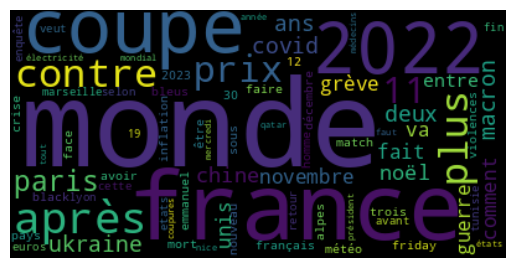

In [193]:
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=df_tfidf_sum.to_dict()['tfidf_sum'])
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

/Users/estelle/.pyenv/versions/3.10.2/envs/quotaclimat/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



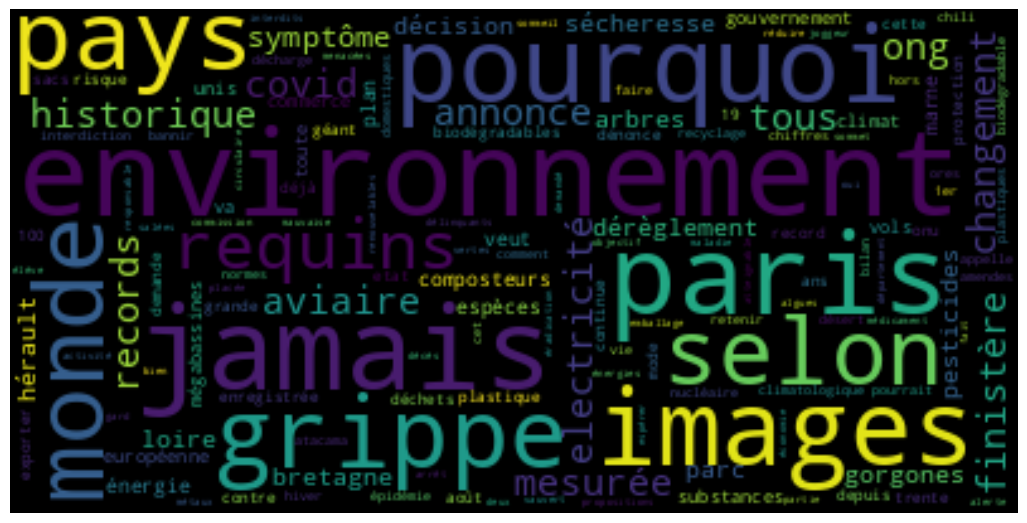

In [186]:
## word cloud per section
## here filtered only on section planete, crise climatique and environnment

vectorizer = TfidfVectorizer(max_df=0.06, min_df=0.01, stop_words=stopwords)
tfidf_positive_climat_topic = vectorizer.fit_transform(df[(df.planete !=0)|(df.environnement !=0)|(df['crise-climatique'] !=0)].news_title)
tfidf_positive_climat_topic_sum = pd.DataFrame(tfidf_positive_climat_topic.T.sum(axis=1), index=vectorizer.get_feature_names(), columns=["tfidf_sum"])

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=tfidf_positive_climat_topic_sum.to_dict()['tfidf_sum'])
plt.figure(figsize=(13,8))

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


/Users/estelle/.pyenv/versions/3.10.2/envs/quotaclimat/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



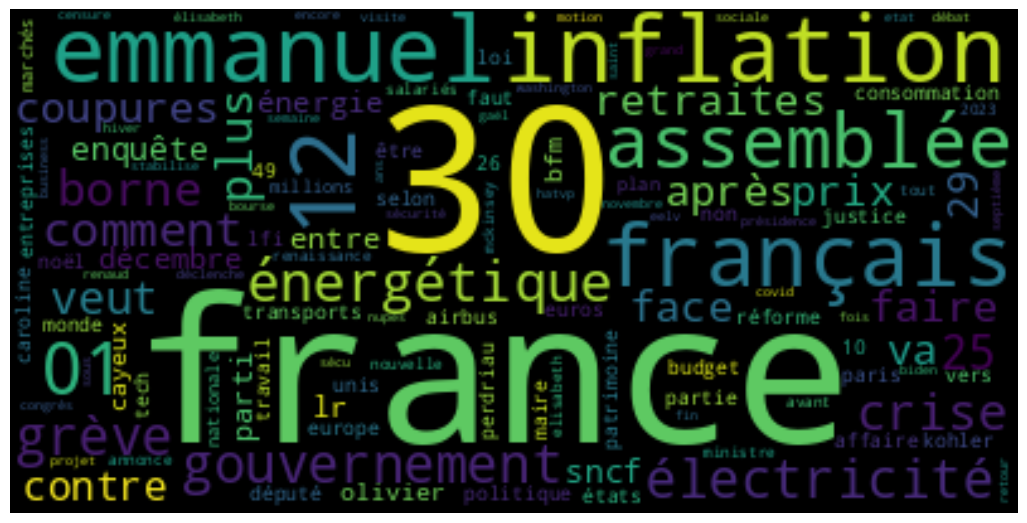

In [195]:
## word cloud per section
## here filtered only on politque economie

vectorizer = TfidfVectorizer(max_df=0.06, min_df=0.01, stop_words=stopwords)
tfidf_positive_climat_topic = vectorizer.fit_transform(df[(df.politique !=0)|(df['economie'] !=0)].news_title)
tfidf_positive_climat_topic_sum = pd.DataFrame(tfidf_positive_climat_topic.T.sum(axis=1), index=vectorizer.get_feature_names(), columns=["tfidf_sum"])

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=tfidf_positive_climat_topic_sum.to_dict()['tfidf_sum'])
plt.figure(figsize=(13,8))

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()